In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db



In [2]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [3]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
resultsDb = db.ResultsDb(outDir=outDir)



In [4]:
# get the name of all opsim dbs 
import glob

os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns'
os.chdir(workpath) # change back to work directory
dblist_all.sort()



In [5]:
dblist_all[4]

'baseline_v1.5_10yrs.db'

In [6]:
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid



In [7]:
from lsst.sims.maf.utils import m52snr

class filterPairTGapsDklMetric(metrics.BaseMetric):
    """
    returns
    N_v * np.exp(-Dkl) for each fields
    
    Parameters:
        colname: 
        fltpair: filter pair, eg ['r', 'i']
        snr_lim: list, signal to noise ratio (fiveSigmaDepth) threshold for fltpair, default [5, 5]
        filename: output a csv table for time gaps of each field
    
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['r', 'i'], tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
                 filename=None, dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.mag_lim = mag_lim
        self.dataout = dataout
        self.tmin = tmin
        self.tmax = tmax
        self.bins = bins
        
        self.Nrun = 0   # record the how many time run run()
        if filename!=None:
            if os.path.isfile(filename):
                # rm old file
                os.system("rm {}".format(filename))
                
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
    
    def get_Dkl(self, values):
        '''kl divergence for histogram'''
        if values.any():
            values = values + 0.00001  # make each element non-zero
            prob = (values) / values.sum()  
        
            prob_uni = np.ones( len(prob) ) / len(prob)
            return np.sum( prob_uni * np.log(prob_uni / prob) )
        
        else:
            return np.NaN
        
    def get_FoM_i(self, dT_all, tmin=0, tmax=1.5/24, bins=50):
        """return FoM from array of metricValues"""
                
        dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
        Nv = len(dT_tlim)
    
        values, bins_ = np.histogram(dT_tlim, bins=bins);
    
        Dkl = self.get_Dkl(values)
    
        FoM_i = Nv * np.exp(-Dkl)
        
        #print(self.Nrun, len(dT_all), Nv, Dkl, FoM_i)
        return Nv, Dkl, FoM_i, dT_tlim
      
    def run(self, dataSlice, slicePoint=None):
        
        # return all possible time gaps for each fields
        
        f0 = self.fltpair[0]
        f1 = self.fltpair[1]
        
        #check input config
        #print(f0, f1, self.tmin, self.tmax, self.mag_lim)
            
        # sort dataSlice
        
        idx0 = ( dataSlice['filter'] == f0 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[0])
        idx1 = ( dataSlice['filter'] == f1 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[1])
        
        timeCol0 = dataSlice['observationStartMJD'][idx0]
        timeCol1 = dataSlice['observationStartMJD'][idx1]

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        # calculate time gaps matrix
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) ) 
        
        # collect all time gaps
        if f0==f1:
            # get only triangle part
            dt_tri = np.tril(diffmat, -1)
            dT = dt_tri[dt_tri!=0]    # flatten lower triangle 
        else:
            dT = diffmat.flatten()

        # Nv, Dkl, FoM_i, dT_tlim = self.get_FoM_i(dT, tmin=self.tmin, tmax=self.tmax, bins=self.bins)
        dT_tlim = dT[(dT>self.tmin)&(dT<self.tmax)] # in days
        Nv = len(dT_tlim)
        # print(self.Nrun, np.min(dataSlice['fiveSigmaDepth'][idx0]), np.min(dataSlice['fiveSigmaDepth'][idx1]),)
        self.Nrun += 1
        # write results to csv file
        fieldRA = np.mean(dataSlice['fieldRA']) ,
        fieldDec = np.mean(dataSlice['fieldDec']),
        
        dic = {'Nrun': self.Nrun, 
            'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
            'Nv': Nv,
            #'Dkl': Dkl,
            #'FoM_i': FoM_i,
            #'dT_lim': dT_lim,
            'dT_tlim': dT_tlim
              }

        if self.filename!=None:
            self.save_to_file(dic, filename=self.filename)
        
        if self.dataout:
            # return dT
            result = dic
            return result
        else:
        #    f0 = self.fltpair[0]
        #    f1 = self.fltpair[1]
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result) 



In [ ]:
%%time
dbname = dblist_all[4]
tmin = 5/60/60/24 # in days
tmax = 3e8/60./60./24

# histogram in log space
bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)

metricSky = runMetric(dbname, fltpair='uu', sqlstr='proposalId=1', tmin=tmin, tmax=tmax,bins=bins)



In [63]:
def runMetric(dbname, fltpair, ipix_ms=None, nside=16, sqlstr=None, **kwargs):
    """run filterPairTGapsMetric
    dbname: name of opsim database
    fltpair: filter pair, eg: 'ri'
    ipix_ms: pixIds of footprint
    **kwargs: pass to filterPairTGapsDklMetric
    """
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    #fltpair = ['r', 'i']
    
    if ipix_ms!=None:
        # use UserPointsSlicer for minisurvey
        ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
        slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    else:
        # use HealpixSlicer 
        slicer = slicers.HealpixSlicer(nside=nside)
    
    # metric, slicer, constraint
    metric = filterPairTGapsDklMetric( colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=fltpair,
                                   **kwargs )
    
    sqlconstraint = 'filter in ("{}", "{}")'.format(*fltpair)
    if sqlstr!=None:
        sqlconstraint += ' and {}'.format(sqlstr)
        
    # bundle
    newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # group bundle
    bundleDict = {'newMetricSky':newMetricSky}
    group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)
    
    # run
    group.runAll()
    #group.plotAll(closefigs = False)
    return newMetricSky



In [64]:
fltpairs = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy',
           'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy' ]

In [65]:
dblist_all[3:5]

['baseline_2snaps_v1.5_10yrs.db', 'baseline_v1.5_10yrs.db']

In [66]:
%%time 

dicFoM = {}
dicFoM['db'] = dblist_all[3:5]

# select survey footprint, None for all fields
nside = 16
ipix_ms = None
sqlstr = 'proposalId=1 and note not like "%DD% and night<730"' # remove DD fields
magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]
for fltpair in fltpairs:  
    dicFoM[fltpair] = []
    dataRaw[fltpair] = {}
    for dbname in dicFoM['db']:
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24
            
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            tmax = 1.5/24 # in days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, dataout=True );
        
        arr = metricSky.metricValues.data
        arr_valid = arr[ arr != None ]
        df = pd.DataFrame.from_records(arr_valid)
        
        #FoM = np.nansum( df['FoM_i'].values )
        FoM = np.nansum( df['Nv'].values )
        
        dicFoM[fltpair].append(FoM)
        dataRaw[fltpair][dbname] = df
        print('>>>', fltpair, dbname, FoM)
    df_fom = pd.DataFrame(dicFoM)
    df_fom.to_csv('tgapsDkl_FoM_wfd.csv', index=False)
    # save raw to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir + '/dT_skymap.pkl',)



Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 and note not like "%DD% and night<730" for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 108851 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu baseline_2snaps_v1.5_10yrs.db 2103640
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 and note not like "%DD% and night<730" for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'filter']
Found 117746 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu baseline_v1.5_10yrs.db 2468080
Healpix slicer using NSIDE=16, approximate resolution 219.8

In [8]:
dataraw = pd.read_pickle( outDir + '/dT_skymap.pkl' )

In [10]:
dataraw['uu'][dblist_all[4]]

,Nrun,Nv,dT_tlim,pixId
0,1,228,"[2543.0299859689258, 2517.1657840843764, 25.86...",1376
1,2,151,"[325.06176144188794, 2897.0894808574594, 3222....",1377
2,3,105,"[1061.1107692982987, 1388.0824860240027, 2449....",1378
3,4,190,"[681.1237290293211, 348.9774169290613, 332.146...",1379
4,5,105,"[2155.1549509010947, 2155.2038098323683, 0.048...",1380
5,6,119,"[1854.9268669024896, 350.0508093055905, 1504.8...",1381
6,7,55,"[2159.0847757158335, 3275.009703620133, 1115.9...",1382
7,8,104,"[330.0973442412942, 1799.0754751530185, 2129.1...",1383
8,9,190,"[2499.2178868162446, 679.1726300520895, 1820.0...",1384
9,10,89,"[34.98745522057288, 318.0949542224407, 353.082...",1385


#### plot

In [71]:
def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmin=0, vmax=None, colorbar=True):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
    '''
    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=vmin, vmax=vmax)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)



In [12]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

r i 1462


[]

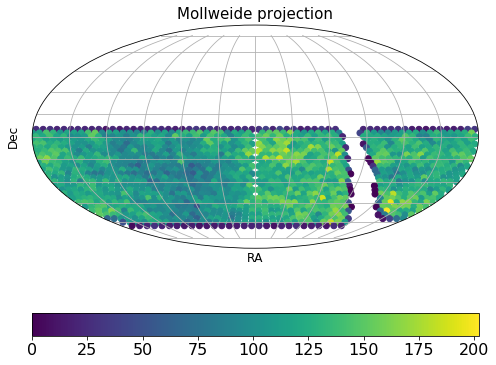

In [57]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'mollweide'}, )#constrained_layout=True);

ax = axs
f0, f1 = 'r', 'i'
dbname = dblist_all[3]
df = dataraw['{}{}'.format(f0,f1)][dbname]
ipix = df['pixId'].values

RA, Dec = pix2radec(nside=16, ipix=ipix)
c = df['Nv'].values

print(f0, f1, len(c))
plot_mwd(ax, RA, Dec, c)
ax.set_xticklabels([])     
ax.set_yticklabels([]) 

In [68]:
dataraw = pd.read_pickle( outDir + '/dT_skymap.pkl' )

g g 1460


[]

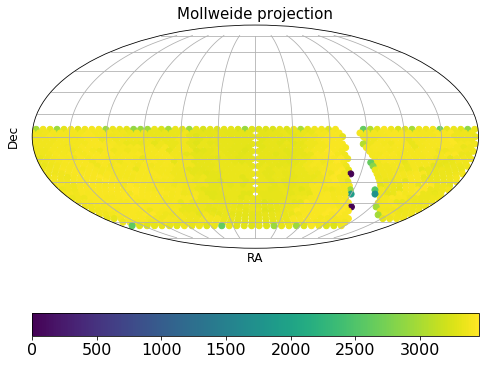

In [70]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'mollweide'}, )#constrained_layout=True);

ax = axs
f0, f1 = 'g', 'g'
dbname = dblist_all[4]
df = dataraw['{}{}'.format(f0,f1)][dbname]
ipix = df['pixId'].values

RA, Dec = pix2radec(nside=16, ipix=ipix)
c = df['dT_tlim'].apply(lambda x: np.max(x) if len(x)!=0 else 0).values

print(f0, f1, len(c))
plot_mwd(ax, RA, Dec, c)
ax.set_xticklabels([])     
ax.set_yticklabels([]) 

g g 1460


[]

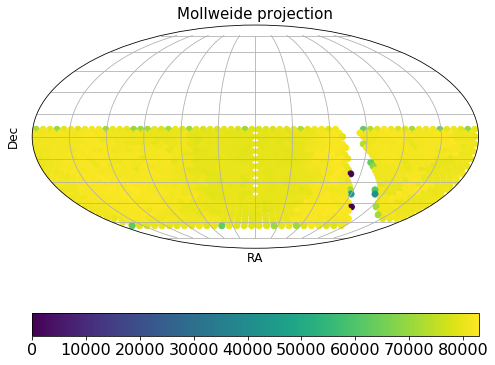

In [67]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'mollweide'}, )#constrained_layout=True);

ax = axs
f0, f1 = 'g', 'g'
dbname = dblist_all[4]
df = dataraw['{}{}'.format(f0,f1)][dbname]
ipix = df['pixId'].values

RA, Dec = pix2radec(nside=16, ipix=ipix)
c = df['dT_tlim'].apply(lambda x: np.max(x)*24 if len(x)!=0 else 0).values

print(f0, f1, len(c))
plot_mwd(ax, RA, Dec, c)
ax.set_xticklabels([])     
ax.set_yticklabels([]) 

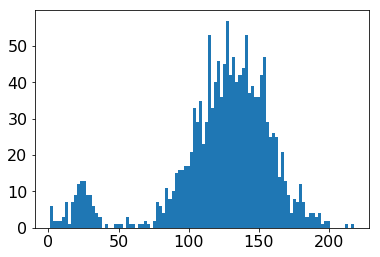

In [60]:
plt.hist(c, bins=100) ;

In [ ]:
df['dT_tlim'].apply(lambda x: np.max(x) if len(x)!=0 else np.inf)


In [49]:
def plot_dT_skymap( dbname, df_data ):
    
    figsize = (20, 20)
    fig, axs = plt.subplots(6, 6, figsize=figsize, subplot_kw={'projection': 'mollweide'}, )#constrained_layout=True);
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
    
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            if f0==f1:
    
                ax = axs[fdict[f0], 5]
                axs[fdict[f0], fdict[f1]].axis('off')
                vmax = 20000
                
            else:
                axs[fdict[f0], fdict[f1]].axis('off')
                ax = axs[fdict[f1], fdict[f0]]
                vmax = 250
            
            fpair = '{}{}'.format(f0, f1)
            df = df_data[fpair][dbname]
            ipix = df['pixId'].values
            
            RA, Dec = pix2radec(nside=16, ipix=ipix)
            
            c = df['Nv'].values
            #print(f0, f1, len(c))
            plot_mwd(ax, RA, Dec, c, title=fpair, vmax=vmax)
            ax.set_xticklabels([])     
            ax.set_yticklabels([]) 
            
    for i in range(6):
        #axs[i, i].axis('off')
        axs[i, 5].axis('on')    
 

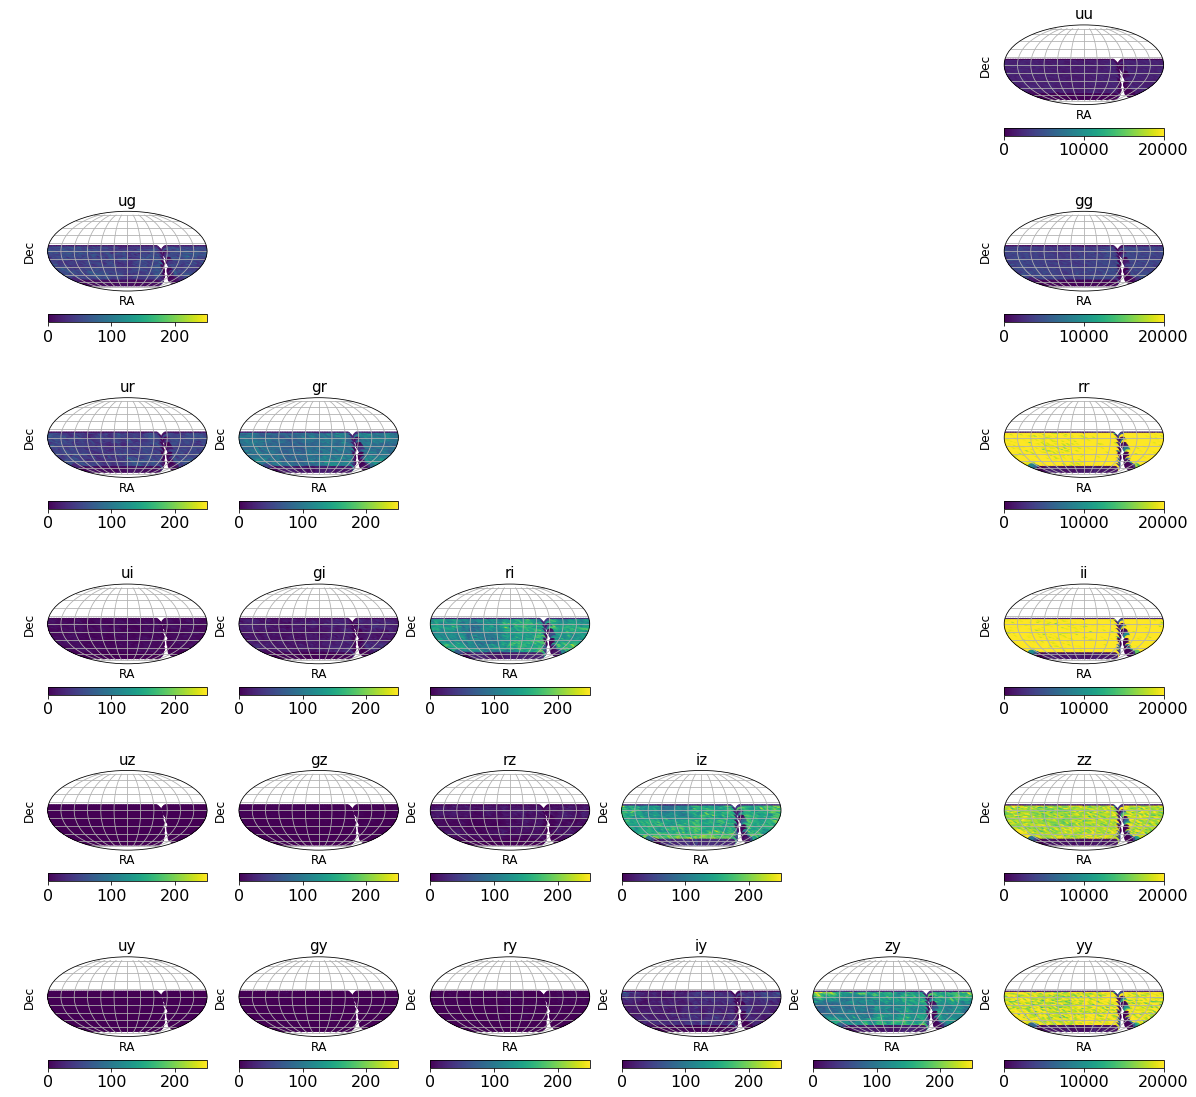

In [50]:
plot_dT_skymap( dblist_all[4], df_data=dataraw )

In [52]:
dataraw.index

Index(['baseline_2snaps_v1.5_10yrs.db', 'baseline_v1.5_10yrs.db'], dtype='object')

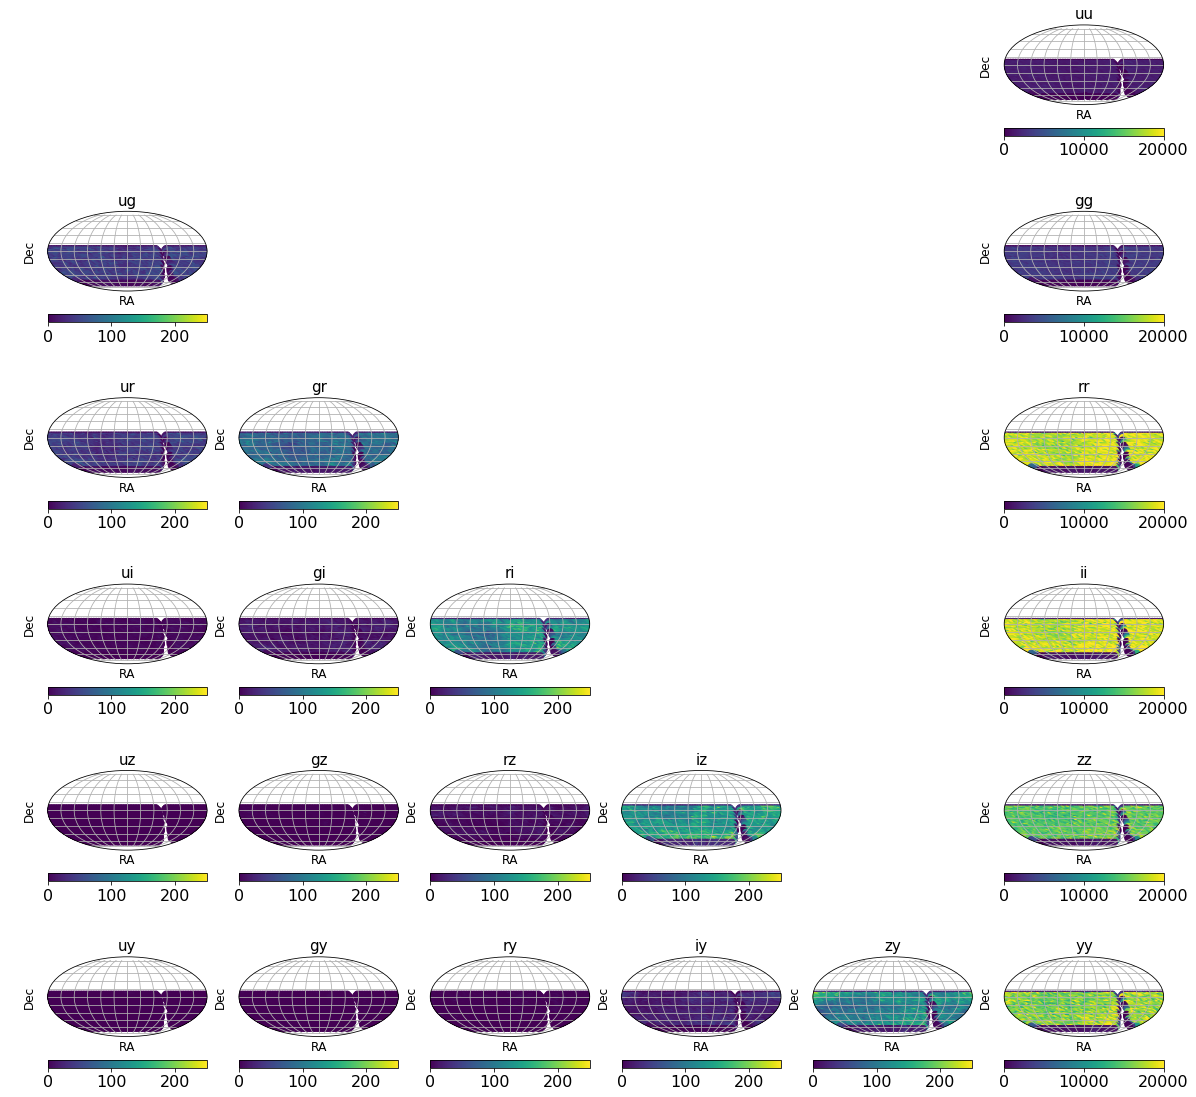

In [53]:
plot_dT_skymap( dblist_all[3], df_data=dataraw )

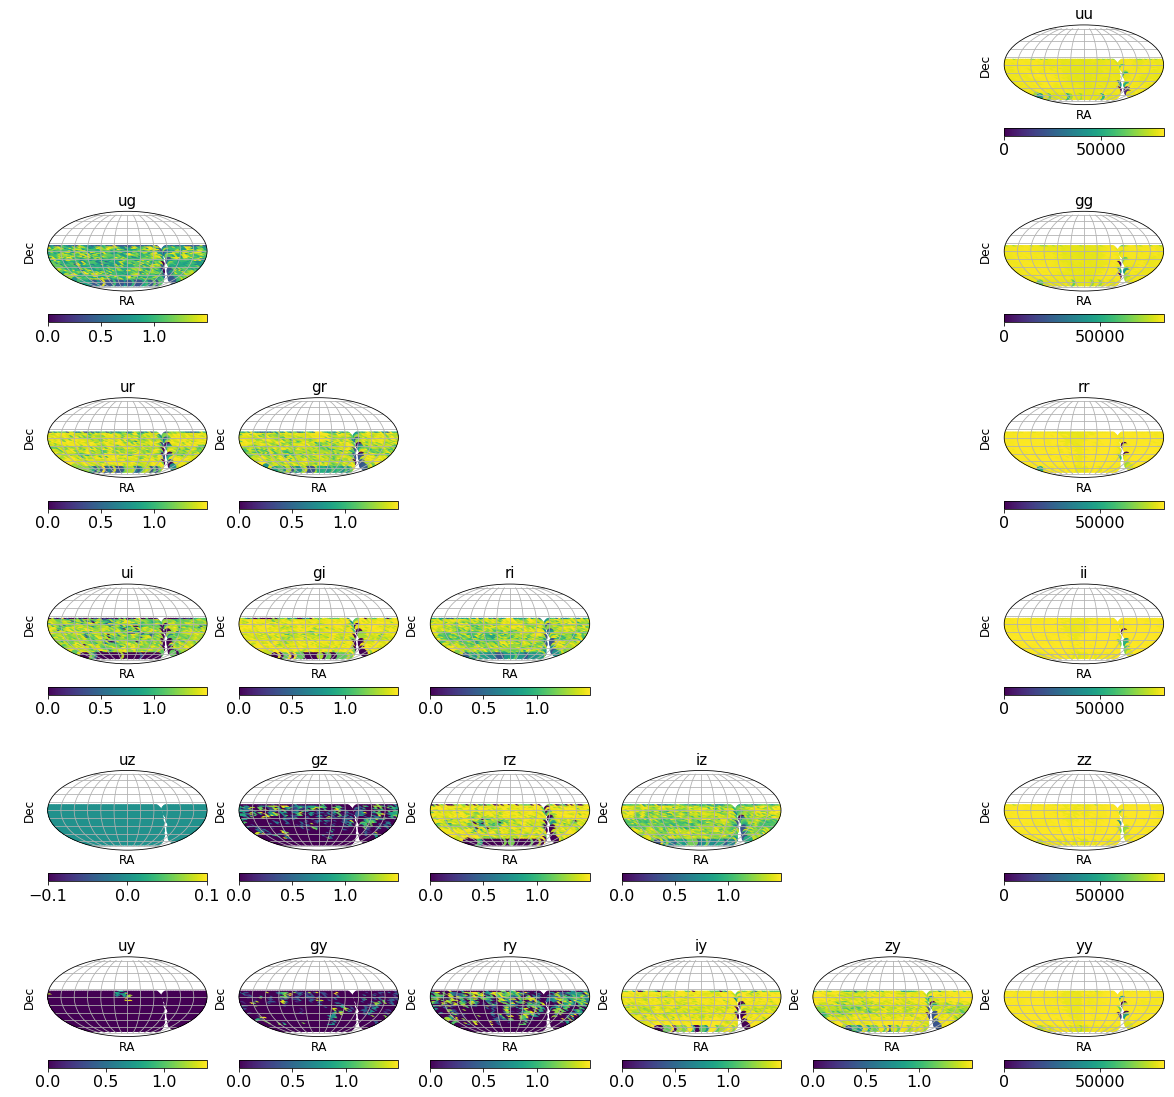

In [45]:
dbname = dblist_all[4]

figsize = (20, 20)
fig, axs = plt.subplots(6, 6, figsize=figsize, subplot_kw={'projection': 'mollweide'}, )#constrained_layout=True);
flt = ['u', 'g', 'r', 'i', 'z', 'y']
fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        if f0==f1:

            ax = axs[fdict[f0], 5]
            axs[fdict[f0], fdict[f1]].axis('off')
            #vmax = 20000
            
        else:
            axs[fdict[f0], fdict[f1]].axis('off')
            ax = axs[fdict[f1], fdict[f0]]
            #vmax = 250
        
        fpair = '{}{}'.format(f0, f1)
        df = dataraw[fpair][dbname]
        ipix = df['pixId'].values
        
        RA, Dec = pix2radec(nside=16, ipix=ipix)
        
        c = df['dT_tlim'].apply(lambda x: np.max(x)*24 if len(x)!=0 else 0).values

        #print(f0, f1, len(c))
        plot_mwd(ax, RA, Dec, c, title=fpair,)
        ax.set_xticklabels([])     
        ax.set_yticklabels([]) 
        
for i in range(6):
    #axs[i, i].axis('off')
    axs[i, 5].axis('on')    



In [48]:
3600 * 24

86400

In [46]:
c

array([79966.14967036, 80661.30458781, 80063.29163557, ...,
       82122.85024863, 81379.88445768, 78768.18339438])